In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [7]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | The check in process and rew...
1,"✅ Trip Verified | We flew in November 2023, ..."
2,✅ Trip Verified | I left for London from Johan...
3,✅ Trip Verified | After an excellent flight ...
4,✅ Trip Verified | On a recent flight from Cy...


In [12]:
df.to_csv("Data/BA_reviews.csv")

In [25]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [14]:
# Unduh resource stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

# Load dataset
df = pd.read_csv('BA_reviews.csv')

# Inspect data
print("Dataset Loaded. Preview:")
print(df.head())

Dataset Loaded. Preview:
   Unnamed: 0                                            reviews
0           0  ✅ Trip Verified | The check in process and rew...
1           1  ✅ Trip Verified |   We flew in November 2023, ...
2           2  ✅ Trip Verified | I left for London from Johan...
3           3  ✅ Trip Verified |   After an excellent flight ...
4           4  ✅ Trip Verified |   On a recent flight from Cy...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zakie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zakie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zakie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zakie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zakie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\zakie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng t

In [15]:
# hapus yang tidak perlu
df.reviews= df.reviews.str.split('|',expand=True)[1]
df

,Unnamed: 0,reviews
0,0,The check in process and reward/loyalty progr...
1,1,"We flew in November 2023, but it took this ..."
2,2,I left for London from Johannesburg at 21:15 ...
3,3,After an excellent flight on a 777 CPT to L...
4,4,On a recent flight from Cyprus BA621 on 23/...
...,...,...
995,995,London Gatwick to San Jose Costa Rica. This w...
996,996,"Inflight crew were very helpful, polite and ..."
997,997,From Toronto to Pisa British Airways used a w...
998,998,A very good service on board this flight with...


In [16]:
# Cleaning Data
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub('[^A-Za-z]+', ' ', str(text))  # Replace non-letters with space
    return text.strip()

# Apply cleaning
df['cleaned_review'] = df['reviews'].astype(str).apply(clean_text)
# Save cleaned data
df.to_csv('cleaned_reviews.csv', index=False)
print("Cleaned data saved to 'cleaned_reviews.csv'.")

Cleaned data saved to 'cleaned_reviews.csv'.


In [17]:
# Dictionary untuk memetakan POS tag NLTK ke WordNet
pos_dict = {
    'J': wordnet.ADJ,  # Adjective
    'V': wordnet.VERB,  # Verb
    'N': wordnet.NOUN,  # Noun
    'A': wordnet.ADV    # Adverb
}

def pos_tagger(text):
    """
    Melakukan tokenisasi, POS tagging, dan menghapus stopwords serta tanda baca.

    Args:
    text (str): Teks input.

    Returns:
    list: Daftar tuple (kata, POS) setelah stopwords dihapus dan POS dimapping ke WordNet.
    """
    # Tokenisasi dan POS tagging
    tokens_with_pos = pos_tag(word_tokenize(text))

    # Stopwords dalam bahasa Inggris
    stop_words = set(stopwords.words('english'))

    # Tanda baca
    punctuation = set(string.punctuation)

    # List hasil untuk menyimpan token yang difilter
    filtered_tokens = []

    for word, tag in tokens_with_pos:
        word_lower = word.lower()  # Konversi ke lowercase untuk pencocokan dengan stopwords
        if word_lower not in stop_words and word_lower not in punctuation:  # Abaikan stopwords dan tanda baca
            # Mapping POS tag ke format WordNet
            pos = pos_dict.get(tag[0], wordnet.NOUN)  # Default ke kata benda jika POS tidak cocok
            filtered_tokens.append((word_lower, pos))
    
    return filtered_tokens

df['POS tagged'] = df['cleaned_review'].apply(pos_tagger)
df.head()

,Unnamed: 0,reviews,cleaned_review,POS tagged
0,0,The check in process and reward/loyalty progr...,the check in process and rewardloyalty program...,"[(check, n), (process, n), (rewardloyalty, n),..."
1,1,"We flew in November 2023, but it took this ...",we flew in november but it took this long to s...,"[(flew, n), (november, n), (took, n), (long, n..."
2,2,I left for London from Johannesburg at 21:15 ...,i left for london from johannesburg at on dece...,"[(left, n), (london, n), (johannesburg, n), (d..."
3,3,After an excellent flight on a 777 CPT to L...,after an excellent flight on a cpt to lhr the ...,"[(excellent, n), (flight, n), (cpt, n), (lhr, ..."
4,4,On a recent flight from Cyprus BA621 on 23/...,on a recent flight from cyprus ba on the secon...,"[(recent, n), (flight, n), (cyprus, n), (ba, n..."


In [19]:
# Lemmatization
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data):
    """
    Melakukan lemmatization pada teks berdasarkan hasil POS tagging.

    Args:
    pos_data (list): Daftar pasangan kata dan POS.

    Returns:
    str: Teks yang sudah dilemmatize.
    """
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:  # Jika POS tidak ada, gunakan kata asli
            lemma = word
        else:  # Lakukan lemmatization
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        lemma_rew += " " + lemma
    return lemma_rew.strip()

# Terapkan lemmatization ke kolom POS tagged
df['Lemma'] = df['POS tagged'].apply(lemmatize)

# Simpan hasil ke file baru
output_path = 'Data/BA_reviews_cleaned.csv'
df.to_csv(output_path, index=False)

In [20]:
df[['cleaned_review','Lemma']]

,cleaned_review,Lemma
0,the check in process and rewardloyalty program...,check process rewardloyalty program mess never...
1,we flew in november but it took this long to s...,flew november took long seek satisfactory resp...
2,i left for london from johannesburg at on dece...,left london johannesburg december issue flight...
3,after an excellent flight on a cpt to lhr the ...,excellent flight cpt lhr return good ba moved ...
4,on a recent flight from cyprus ba on the secon...,recent flight cyprus ba second cabin door clos...
...,...,...
995,london gatwick to san jose costa rica this was...,london gatwick san jose costa rica similar exp...
996,inflight crew were very helpful polite and car...,inflight crew helpful polite caring though cal...
997,from toronto to pisa british airways used a we...,toronto pisa british airway used wet leased ai...
998,a very good service on board this flight with ...,good service board flight british airway lhr v...


In [21]:
# Inisialisasi SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Fungsi untuk menghitung skor sentimen menggunakan VADER
def vadersentimentanalysis(review):
    """
    Menghitung skor sentimen compound menggunakan VADER.

    Args:
    review (str): Teks ulasan.

    Returns:
    float: Skor compound dalam kisaran [-1, 1].
    """
    vs = analyzer.polarity_scores(review)
    return vs['compound']

# Terapkan fungsi sentimen ke kolom 'Lemma'
df['Sentiment'] = df['Lemma'].apply(vadersentimentanalysis)

# Fungsi untuk mengkategorikan skor sentimen
def vader_analysis(compound):
    """
    Mengkategorikan skor compound ke dalam sentimen (Positive, Negative, Neutral).

    Args:
    compound (float): Skor compound dari VADER.

    Returns:
    str: Kategori sentimen ('Positive', 'Negative', 'Neutral').
    """
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Terapkan fungsi analisis sentimen ke kolom 'Sentiment'
df['Analysis'] = df['Sentiment'].apply(vader_analysis)
df.head()

,Unnamed: 0,reviews,cleaned_review,POS tagged,Lemma,Sentiment,Analysis
0,0,The check in process and reward/loyalty progr...,the check in process and rewardloyalty program...,"[(check, n), (process, n), (rewardloyalty, n),...",check process rewardloyalty program mess never...,-0.7003,Negative
1,1,"We flew in November 2023, but it took this ...",we flew in november but it took this long to s...,"[(flew, n), (november, n), (took, n), (long, n...",flew november took long seek satisfactory resp...,-0.2978,Negative
2,2,I left for London from Johannesburg at 21:15 ...,i left for london from johannesburg at on dece...,"[(left, n), (london, n), (johannesburg, n), (d...",left london johannesburg december issue flight...,-0.9654,Negative
3,3,After an excellent flight on a 777 CPT to L...,after an excellent flight on a cpt to lhr the ...,"[(excellent, n), (flight, n), (cpt, n), (lhr, ...",excellent flight cpt lhr return good ba moved ...,0.9887,Positive
4,4,On a recent flight from Cyprus BA621 on 23/...,on a recent flight from cyprus ba on the secon...,"[(recent, n), (flight, n), (cyprus, n), (ba, n...",recent flight cyprus ba second cabin door clos...,-0.8271,Negative


In [22]:
vader_counts = df['Analysis'].value_counts()
vader_counts

Analysis
Negative    454
Positive    445
Neutral     101
Name: count, dtype: int64

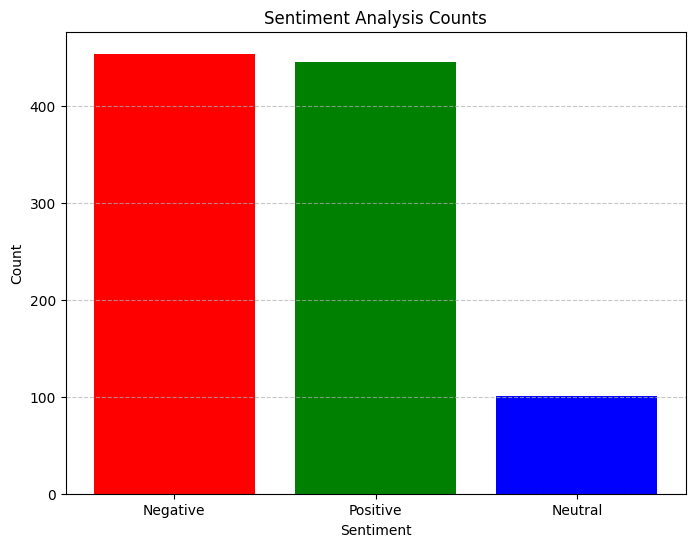

In [24]:
# Data for visualization
vader_counts = {
    "Negative": 454,
    "Positive": 445,
    "Neutral": 101
}

# Extract labels and values
labels = list(vader_counts.keys())
values = list(vader_counts.values())

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['red', 'green', 'blue'])
plt.title('Sentiment Analysis Counts')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Generating WordCloud...


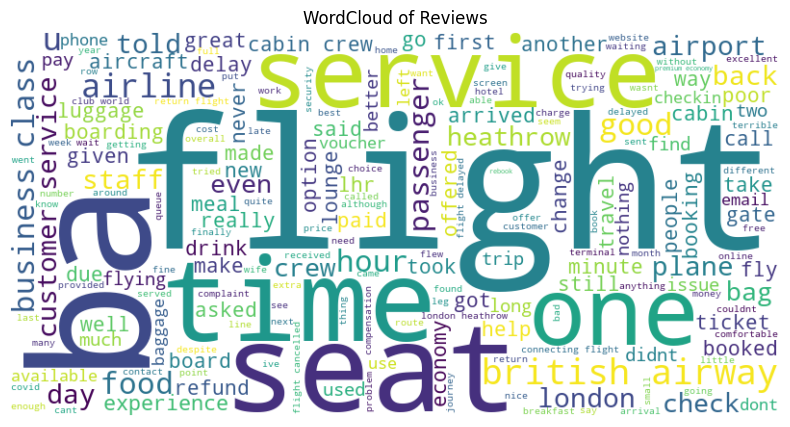

Analysis completed successfully.


In [31]:
# WordCloud
print("Generating WordCloud...")
all_text = ' '.join(df['Lemma'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Reviews')
plt.show()

print("Analysis completed successfully.")